This code is based on an assignment from the University of Michigan's Coursera course titled Applied Machine Learning in Python. I have expanded on the assignment by ROC curves, performance assessments, new graph metrics for prediction, and some helper functions to better understand the netwoork structure.

**Skills demonstrated:** classification, scikit-learn, NetworkX, model evaluation, general coding

Overview: 

> The nodes in the graph defined in assets/email_prediction_NEW.txt represent employees at a company and two nodes are connected if either employee has ever sent the other an email. The dataset assets/Future_Connections.csv contains pairs of currently unconnected nodes and indicates whether they will form a connection in the future (1) or not (0). This dataset is incomplete, with many labeled None. The missing future connection data is contained in assets/Future_Connections_testing.csv.


Purpose: 
> Train a classifier to predict whether the pairs of nodes with missing information in assets/Future_Connections.csv will form a connection in the future.

Datasets/graph information: 

> - assets/email_prediction_NEW.txt: Contains the graph of employees connected by emails
> - assets/Future_Connections.csv: CSV indexed by pairs of currently unconnected nodes with labels indicating whether they will form connections in the future. Some labels are missing.
> - assets/Future_Connections_testing.csv: CSV containing the labels missing in assets/Future_Connections.csv.
    
Features:

> Each node contains information identifying the department that employee works in and some salary data. The salary data is dropped and unused in this code. All other features are derived from the graph structure. In particular, we consider
> 1. the [Jaccard coefficient](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html)
2. the shortest path between the two nodes if they are in the same connected component
3. the [resource allocation index](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html)
4. the [preferential attachment score](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html)
5. the [common neighbor centrality score](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.common_neighbor_centrality.html#networkx.algorithms.link_prediction.common_neighbor_centrality)

Target variable:

> Future Connection - Target label for training. 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_recall_fscore_support
from connect_utils import *

In [2]:
G = pickle.load(open('assets/email_prediction_NEW.txt', 'rb'))

network_feature_summary(G)

The graph contains 1005 nodes and 16706 edges and is undirected, unweighted, and unconnected.
It contains 20 connected components.
The three largest connected components are of size 986, 1, and 1.
The three smallest connected components are of size 1, 1, and 1.


In [3]:
#list(G.nodes(data=True))[:5] # print the first 5 nodes

In [4]:
#Construct a list of all connected subgraphs
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [5]:
#nx.draw_networkx(S[0])

In [6]:
#Remove unnecessary node data
type(G.nodes)
for i, _ in enumerate(G.nodes):
    G.nodes[i].pop('ManagementSalary')
list(G.nodes(data=True))[:5]

[(0, {'Department': 1}),
 (1, {'Department': 1}),
 (581, {'Department': 3}),
 (6, {'Department': 25}),
 (65, {'Department': 4})]

In [7]:
#Load CSV containing information on future connections
X_orig = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})

In [8]:
#X_orig.head(10)

In [9]:
X, X_test, y = construct_feature_matrix(G, X_orig, shortest_path=True, diam=nx.diameter(S[0]), resource=True)

In [10]:
X.head()

,Jaccard,Shortest_Path,Resource
"(6, 840)",0.073770,2,0.136721
"(4, 197)",0.015504,2,0.008437
"(620, 979)",0.000000,3,0.000000
"(519, 872)",0.060606,2,0.039726
"(382, 423)",0.000000,3,0.000000


In [11]:
# Split X and y into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

#Scale features in X to fall between 0 and 1
scaler = StandardScaler()
scaler.fit(X_train)

#train and test random forest classifier
clf = RandomForestClassifier(n_estimators = 50, max_depth = 8, random_state = 0)
clf.fit(scaler.transform(X_train), np.ravel(y_train))
y_probs = clf.predict_proba(scaler.transform(X_valid))
#print(roc_auc_score(y_valid, y_probs[:,1]))

In [12]:
#Load dataset containing missing future connection data
y_test = pd.read_csv('assets/Future_Connections_testing.csv', index_col=0, header = None, converters={0: eval})

In [13]:
#test the classifier's performance on this missing data
y_probs_test = clf.predict_proba(scaler.transform(X_test))[:,1]
#print(roc_auc_score(y_test, y_probs_test))

In [14]:
#Construct and plot the ROC curve. Indicate the point on the curve closest to the upper-left corner of the domain
fpr, tpr, thresh_info = roc_info(y_test, y_probs_test)

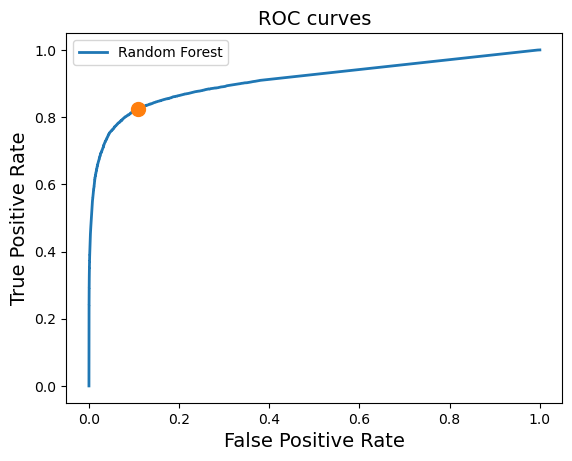

In [15]:
roc_plotter(fpr, tpr, thresh_info,'Random Forest')

In [16]:
#print(y_pred > 0.1)
rf_thresh = thresh_info[-1]
rf_auc = roc_auc_score(y_test, y_probs_test)
rf_acc = accuracy_score(y_test, (y_probs_test > rf_thresh))
#rf_recall = recall_score(y_test, (y_probs_test > rf_thresh))
rf_prec, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, (y_probs_test > rf_thresh))

print('We can compare the AUC and accuracy scores of each model:')

print(f'Random forest AUC score: {rf_auc:.3f}')
print(f'Random forest accuracy score at optimal probability threshold: {rf_acc:.3f}')
print(f'Random forest true positive rate (recall) at optimal probability threshold: {rf_recall[1]:.3f}')
print(f'Random forest precision at optimal probability threshold: {rf_prec[1]:.3f}')
print(f'Random forest F1 score at optimal probability threshold: {rf_f1[1]:.3f}')
print(f'Random forest false positive rate at optimal probability threshold: {thresh_info[0]:.3f}')



We can compare the AUC and accuracy scores of each model:
Random forest AUC score: 0.909
Random forest accuracy score at optimal probability threshold: 0.886
Random forest true positive rate (recall) at optimal probability threshold: 0.824
Random forest precision at optimal probability threshold: 0.402
Random forest F1 score at optimal probability threshold: 0.540
Random forest false positive rate at optimal probability threshold: 0.109


Below we summarize the performance of the model in a confusion matrix

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(113.9222222222222, 0.5, 'True label'),
 Text(0.5, 1.0, 'Confusion matrix')]

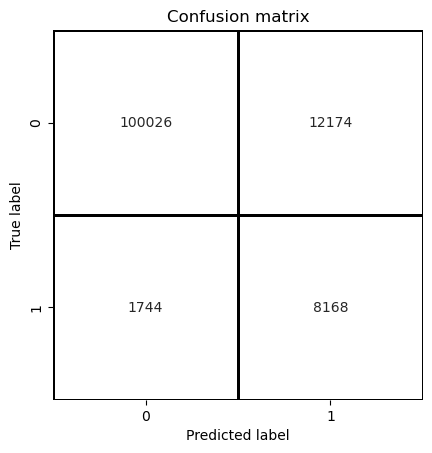

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_probs_test>rf_thresh, labels=clf.classes_)

ax = sns.heatmap(cm, fmt='d', annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=1, linecolor='k',  # draw black grid lines
            cbar=False)                     # disable colorbar
ax.set(xlabel="Predicted label", ylabel="True label", title='Confusion matrix')

The following confusion matrix divides each row of cm above by that row's sum. The result is a confusion matrix containing the true and false positive and negative rates of the form

\[[tpr, fpr], [fnr, tnr]\]

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(113.9222222222222, 0.5, 'True label'),
 Text(0.5, 1.0, 'Confusion matrix (rates)')]

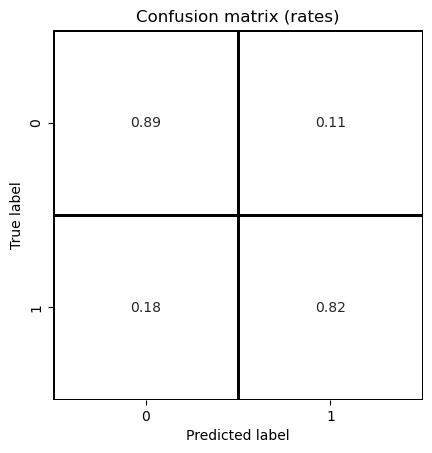

In [18]:
cm_rates = cm/np.sum(cm, axis=1, keepdims=True)

ax1 = sns.heatmap(cm_rates, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=1, linecolor='k',  # draw black grid lines
            cbar=False)                     # disable colorbar
ax1.set(xlabel="Predicted label", ylabel="True label", title='Confusion matrix (rates)')

In [23]:
#The following combines the totals from the original confusion matrix and the rates from cm_rates into a single dataframe
v = list(zip(cm.flatten().tolist(),np.around(cm_rates, 3).flatten().tolist()))
print(v)
cm_with_rates = pd.DataFrame([v[i:i+2] for i in range(0, len(v), 2)])
cm_with_rates

[(100026, 0.891), (12174, 0.109), (1744, 0.176), (8168, 0.824)]


,0,1
0,"(100026, 0.891)","(12174, 0.109)"
1,"(1744, 0.176)","(8168, 0.824)"
